In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objs as go 
import plotly.offline as py 
import math
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

## Fetch Dataset

This is elliptic++ dataset, the following data preprocessing are all for elliptic++. For elliptic, please do your own implementation

In [3]:
import gdown
!gdown --fuzzy "https://drive.google.com/file/d/19q09IFhfkOOBOXvn_dKhWjILJtjCcsjc/view?usp=drive_link"
!gdown --fuzzy "https://drive.google.com/file/d/1DiBxn8TXdbJqoSw58pYUeaqO3oOKhuQO/view?usp=drive_link"
!gdown --fuzzy "https://drive.google.com/file/d/1Q2yG_CIDvfdGP-fKVPSw979EYgQukjz5/view?usp=drive_link"

Downloading...
From (original): https://drive.google.com/uc?id=19q09IFhfkOOBOXvn_dKhWjILJtjCcsjc
From (redirected): https://drive.google.com/uc?id=19q09IFhfkOOBOXvn_dKhWjILJtjCcsjc&confirm=t&uuid=253c15ff-8802-4f69-be84-17b4f1fce4af
To: /Users/fffuuuming/Desktop/study/master_1_2/fintech/final_project/impl/elliptic-fork/Transactions Dataset/txs_features.csv
100%|████████████████████████████████████████| 695M/695M [00:44<00:00, 15.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DiBxn8TXdbJqoSw58pYUeaqO3oOKhuQO
To: /Users/fffuuuming/Desktop/study/master_1_2/fintech/final_project/impl/elliptic-fork/Transactions Dataset/txs_classes.csv
100%|██████████████████████████████████████| 2.36M/2.36M [00:00<00:00, 11.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q2yG_CIDvfdGP-fKVPSw979EYgQukjz5
To: /Users/fffuuuming/Desktop/study/master_1_2/fintech/final_project/impl/elliptic-fork/Transactions Dataset/txs_edgelist.csv
100%|██████████████████████████████████████| 4.47M/4.47M

In [266]:
print("\nTransaction features: \n")
df_txs_features = pd.read_csv("txs_features.csv")
df_txs_features

print("\nTransaction classes: \n")
df_txs_classes = pd.read_csv("txs_classes.csv")
df_txs_classes

print("\nTransaction-Transaction edgelist: \n")
df_txs_edgelist = pd.read_csv("txs_edgelist.csv")
df_txs_edgelist


Transaction features: 


Transaction classes: 


Transaction-Transaction edgelist: 



,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


## Data Preprocessing

1. Drop nodes (transactions) without augmented feature values (0.5% not de-anonymized)
2. Drop edges accordingly

In [294]:
# 1. 把 feature DataFrame 裡含 NaN 的行丟掉
df_txs_features_droped = df_txs_features.dropna()
# 2. 取出還在的 txId（假設 index 就是 txId）
valid_tx = set(df_txs_features_droped.txId)

# 3. 篩邊表：只保留 txId1 與 txId2 都在 valid_tx 裡面的邊
df_txs_edgelist = df_txs_edgelist[
    df_txs_edgelist['txId1'].isin(valid_tx) &
    df_txs_edgelist['txId2'].isin(valid_tx)
].reset_index(drop=True)

In [150]:
df_txs_edgelist

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
233278,158365409,157930723
233279,188708874,188708879
233280,157659064,157659046
233281,87414554,106877725


3. Merge label into txs_features for later index mapping

In [295]:
subset = df_txs_classes[['txId', 'class']]

# 2. 用 merge 把 class 欄併到 txs_features
df_txs_features_droped_merged = df_txs_features_droped.merge(
    subset,
    on='txId',     # 以 txId 當作 key
    how='left'     # 保留 txs_features 所有列，對不到的 class 欄會是 NaN
)

In [152]:
df_txs_features_droped_merged

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class
0,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.534072,0.534072,0.534072,0.534072,1.668990e-01,0.367074,0.266986,0.266986,0.533972,3
1,11108,1,-0.137586,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.127429,...,5.611878,5.611878,5.611878,5.611878,5.861940e-01,5.025584,2.805889,2.805889,5.611778,3
2,51816,1,-0.170103,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160699,...,0.456608,0.456608,0.456608,0.456608,2.279902e-01,0.228518,0.228254,0.228254,0.456508,3
3,68869,1,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,...,8.000000,3.102967,1.000000,9.308900,1.229000e+00,8.079800,4.654400,4.654400,9.308800,2
4,89273,1,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,...,852.164680,852.164680,852.164680,852.164680,1.300000e-07,41.264036,0.065016,0.000441,852.164680,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202799,194747812,49,0.558398,-0.198956,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,0.584665,...,115.952889,115.952889,115.952889,115.952889,1.653300e+00,114.299544,57.976422,57.976422,115.952844,3
202800,194747925,49,0.547658,-0.198956,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,0.573676,...,114.250098,114.250098,114.250098,114.250098,2.035300e-02,114.229700,57.125027,57.125027,114.250053,3
202801,194748063,49,0.543600,-0.198853,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,0.569524,...,113.606771,113.606771,113.606771,113.606771,9.257490e-01,112.680977,56.803363,56.803363,113.606726,3
202802,194748070,49,0.537760,-0.198853,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,0.563549,...,112.680977,112.680977,112.680977,112.680977,3.026970e-01,112.378235,56.340466,56.340466,112.680932,3


4. Normalize augmented features

In [296]:
# For notmalize augmented features
from sklearn.preprocessing import MinMaxScaler

for column in df_txs_features_droped_merged.columns[-18:-1]:
    scaler = MinMaxScaler()
    df_txs_features_droped_merged[column] = scaler.fit_transform(df_txs_features_droped_merged[[column]])

In [155]:
df_txs_features_droped_merged

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class
0,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.000047,0.000047,0.000047,0.000047,8.301504e-05,0.000032,0.000089,8.904096e-05,0.000047,3
1,11108,1,-0.137586,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.127429,...,0.000493,0.000493,0.000493,0.000493,2.915711e-04,0.000444,0.000936,9.357923e-04,0.000493,3
2,51816,1,-0.170103,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160699,...,0.000040,0.000040,0.000040,0.000040,1.134016e-04,0.000020,0.000076,7.612341e-05,0.000040,3
3,68869,1,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,...,0.000702,0.000272,0.000088,0.000817,6.113009e-04,0.000714,0.001552,1.552291e-03,0.000817,2
4,89273,1,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,...,0.074805,0.074805,0.074805,0.074805,6.466160e-11,0.003648,0.000022,1.451405e-07,0.074805,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202799,194747812,49,0.558398,-0.198956,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,0.584665,...,0.010179,0.010179,0.010179,0.010179,8.223464e-04,0.010104,0.019336,1.933576e-02,0.010179,3
202800,194747925,49,0.547658,-0.198956,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,0.573676,...,0.010029,0.010029,0.010029,0.010029,1.012352e-05,0.010098,0.019052,1.905181e-02,0.010029,3
202801,194748063,49,0.543600,-0.198853,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,0.569524,...,0.009973,0.009973,0.009973,0.009973,4.604647e-04,0.009961,0.018945,1.894453e-02,0.009973,3
202802,194748070,49,0.537760,-0.198853,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,0.563549,...,0.009891,0.009891,0.009891,0.009891,1.505606e-04,0.009935,0.018790,1.879015e-02,0.009891,3


5. Set `txId` as the index for the processed DataFrame
6. Updates the index of the Dataframe with ```id_map```
7. Constructs `edge_index`

In [312]:
import torch

df_txs_features_processed = df_txs_features_droped_merged.set_index('txId')

ids_from_src      = df_txs_edgelist['txId1']
ids_from_dst      = df_txs_edgelist['txId2']
all_ids = pd.unique(pd.concat([ids_from_src, ids_from_dst]))
id_map  = {orig_id: idx for idx, orig_id in enumerate(all_ids)}

df_txs_features_processed.index = df_txs_features_processed.index.map(id_map)

src = df_txs_edgelist['txId1'].map(id_map).values
dst = df_txs_edgelist['txId2'].map(id_map).values
edge_index = torch.tensor([src, dst], dtype=torch.long)

8. Extract labels and transform `licit` & `unknown`
9. Extract time steps and create mask

In [313]:
y = df_txs_features_processed['class'].copy()
y[y == 2] = 0   # licit
y[y == 3] = 2   # unknown


time_steps = df_txs_features_processed['Time step']

train_mask, test_mask = time_steps <= 34, time_steps > 34
train_mask = torch.tensor(train_mask.to_numpy(), dtype=torch.bool)
test_mask = torch.tensor(test_mask.to_numpy(), dtype=torch.bool)

time_steps = torch.tensor(time_steps.to_numpy(), dtype=torch.int64)

In [310]:
y

txId
166019.0    2
2324.0      2
6001.0      2
6497.0      0
66.0        0
           ..
165019.0    2
165343.0    2
164927.0    2
164211.0    2
202624.0    2
Name: class, Length: 202804, dtype: int64

10. Drop label & time step

In [315]:
df_txs_features_final = df_txs_features_processed.drop(columns=['class', 'Time step'])

11. Create raw graph (PyTorch Geometric Data)

In [352]:
from torch_geometric.data import Data

x = torch.tensor(df_txs_features_final.values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask, node_time=time_steps)
data.y = torch.from_numpy(data.y.to_numpy().astype(int)).long()

## (i) Naive random splitting on entire graph + joint learning

This approach simply sample negative edge from all edges without considering time step, and it jointly train GAE encoder and classifier without weighted loss or balance data

In [353]:
from torch_geometric.transforms import RandomLinkSplit

splitter = RandomLinkSplit(
    is_undirected=False,
    split_labels=True,          
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0,
    num_val=0,
    num_test=0,
)
train_data, _, _ = splitter(data)

In [354]:
print(data.keys())
print(train_data.keys())

for key in ['x', 'y', 'train_mask', 'test_mask', 'node_time', 'edge_index']:
    print(key, torch.equal(getattr(data, key), getattr(train_data, key)))

['x', 'train_mask', 'node_time', 'test_mask', 'edge_index', 'y']
['x', 'pos_edge_label', 'neg_edge_label_index', 'train_mask', 'node_time', 'pos_edge_label_index', 'neg_edge_label', 'test_mask', 'edge_index', 'y']
x True
y True
train_mask True
test_mask True
node_time True
edge_index False


In [355]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from sklearn.metrics import f1_score, precision_score, recall_score

# 2) Encoder + Classifier
class GAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

class NodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.lin = torch.nn.Linear(in_channels, num_classes)
    def forward(self, z):
        return self.lin(z)

in_feats    = data.num_node_features
hidden_dim  = 128
out_dim     = 64
num_classes = int(data.y[data.y != 2].max() + 1)

encoder    = GAEEncoder(in_feats, hidden_dim, out_dim)
gae_model  = GAE(encoder)
classifier = NodeClassifier(out_dim, num_classes)

optimizer = torch.optim.Adam(
    list(gae_model.parameters()) + list(classifier.parameters()),
    lr=0.01
)
bce_loss = torch.nn.BCEWithLogitsLoss()
ce_loss  = torch.nn.CrossEntropyLoss()

# 3) train() 改用 train_pos/neg
def train():
    gae_model.train()
    classifier.train()
    optimizer.zero_grad()

    # encode on train positive edges
    z = gae_model.encode(train_data.x, train_data.edge_index)

    # AE loss (pos + neg)
    pos = train_data.pos_edge_label_index
    neg = train_data.neg_edge_label_index
    edge_all = torch.cat([pos, neg], dim=1)
    logits_ae = gae_model.decode(z, edge_all)
    labels_ae = torch.cat([
        torch.ones(pos.size(1), device=logits_ae.device),
        torch.zeros(neg.size(1), device=logits_ae.device),
    ])
    loss_ae = bce_loss(logits_ae, labels_ae)

    # classification loss (only known & train_mask)
    mask = data.train_mask.detach().clone() & (data.y != 2)

    logits_cls = classifier(z)
    loss_cls = ce_loss(logits_cls[mask], train_data.y[mask])

    loss = loss_ae + loss_cls
    loss.backward()
    optimizer.step()

    return loss.item(), loss_ae.item(), loss_cls.item()

# 4) evaluate() 只用 train_data.train_pos_edge_index encode
def evaluate():
   
    with torch.no_grad():
        z = gae_model.encode(train_data.x, train_data.edge_index) 
        logits = classifier(z)
        preds  = logits.argmax(dim=1)
   
        mask = data.test_mask.detach().clone() & (data.y != 2)
  
        y_true = data.y[mask].cpu().numpy()
        y_pred = preds[mask].cpu().numpy()

        acc  = (y_true == y_pred).mean().item()
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec  = recall_score(y_true, y_pred, average='macro')
        f1   = f1_score(y_true, y_pred, average='macro')
        print(f"Test Acc={acc:.4f} | "
              f"Precision={prec:.4f} | "
              f"Recall={rec:.4f} | "
              f"F1={f1:.4f}")
        return acc

for epoch in range(1, 101):
    loss_tot, loss_ae, loss_cls = train()
    print(f"Epoch {epoch:03d} | "
              f"Loss={loss_tot:.4f} (AE={loss_ae:.4f}, CLF={loss_cls:.4f})")
    if epoch % 10 == 0:
        test_acc= evaluate()

Epoch 001 | Loss=1.5607 (AE=0.8053, CLF=0.7555)
Epoch 002 | Loss=1.1567 (AE=0.8125, CLF=0.3442)
Epoch 003 | Loss=1.2441 (AE=0.8132, CLF=0.4309)
Epoch 004 | Loss=1.2514 (AE=0.8132, CLF=0.4382)
Epoch 005 | Loss=1.2121 (AE=0.8132, CLF=0.3989)
Epoch 006 | Loss=1.1629 (AE=0.8132, CLF=0.3498)
Epoch 007 | Loss=1.1288 (AE=0.8132, CLF=0.3156)
Epoch 008 | Loss=1.1292 (AE=0.8132, CLF=0.3160)
Epoch 009 | Loss=1.1565 (AE=0.8132, CLF=0.3432)
Epoch 010 | Loss=1.1422 (AE=0.8132, CLF=0.3289)
Test Acc=0.9314 | Precision=0.6373 | Recall=0.5163 | F1=0.5162
Epoch 011 | Loss=1.1088 (AE=0.8132, CLF=0.2955)
Epoch 012 | Loss=1.1049 (AE=0.8133, CLF=0.2916)
Epoch 013 | Loss=1.1184 (AE=0.8133, CLF=0.3051)
Epoch 014 | Loss=1.1244 (AE=0.8133, CLF=0.3112)
Epoch 015 | Loss=1.1149 (AE=0.8133, CLF=0.3016)
Epoch 016 | Loss=1.0977 (AE=0.8133, CLF=0.2844)
Epoch 017 | Loss=1.0886 (AE=0.8133, CLF=0.2753)
Epoch 018 | Loss=1.0964 (AE=0.8133, CLF=0.2831)
Epoch 019 | Loss=1.0990 (AE=0.8133, CLF=0.2858)
Epoch 020 | Loss=1.0881 (

## (ii) Single Graph Dataset

This Dataset contains only single graph, but it samples negative edges based on time step, 
e.g. sample (u, v) only if 
1. (u, v) is not an edge
2. u.time_step = v .time_step

In [288]:
import random

def sample_same_timestep_negative_edges(data: Data, neg_per_pos=1):
    node_time = data.node_time
    edge_index = data.edge_index
    num_nodes = data.num_nodes

    # Step 1: Build positive edge list
    pos_edge_index = edge_index

    # Step 2: Group node indices by time
    time_to_nodes = {}
    for t in torch.unique(node_time):
        nodes = (node_time == t).nonzero(as_tuple=True)[0].tolist()
        time_to_nodes[t.item()] = nodes

    # Step 3: Build a set of existing edges for quick lookup
    existing_edges = set((u.item(), v.item()) for u, v in edge_index.t())

    # Step 4: Sample negative edges within each timestep
    neg_edges = []
    max_trials = 10 * len(nodes) ** 2  # safeguard to avoid infinite loop     

    for t, nodes in time_to_nodes.items():
        trials = 0
        sampled = 0
        while sampled < neg_per_pos * len(pos_edge_index[0]) and trials < max_trials:
            u, v = random.sample(nodes, 2)
            if (u, v) not in existing_edges and (v, u) not in existing_edges and u != v:
                neg_edges.append((u, v))
                sampled += 1
            trials += 1

    # Step 5: Convert to tensors
    neg_edge_index = torch.tensor(neg_edges, dtype=torch.long).t()
    pos_edge_label = torch.ones(pos_edge_index.size(1), dtype=torch.float)
    neg_edge_label = torch.zeros(neg_edge_index.size(1), dtype=torch.float)

    edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    edge_label = torch.cat([pos_edge_label, neg_edge_label], dim=0)

    return edge_label_index, edge_label

In [289]:
edge_label_index, edge_label = sample_same_timestep_negative_edges(data, neg_per_pos=1)

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from sklearn.metrics import f1_score, precision_score, recall_score


# 2) Encoder + Classifier
class GAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)
    
in_feats    = data.num_node_features
hidden_dim  = 128
out_dim     = 64
num_classes = int(data.y[data.y != 2].max() + 1)

encoder    = GAEEncoder(in_feats, hidden_dim, out_dim)
gae_model  = GAE(encoder)

optimizer = torch.optim.Adam(
    list(gae_model.parameters()),
    lr=0.001
)
bce_loss = torch.nn.BCEWithLogitsLoss()



epochs = 100
for epoch in range(1, epochs+1):
    _ = gae_model.train()
    optimizer.zero_grad()

    z = gae_model.encode(data.x, data.edge_index)  # Full graph for encoder
    logits = gae_model.decode(z, edge_label_index).view(-1)
    loss = F.binary_cross_entropy_with_logits(logits, edge_label)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")

Epoch 001 | Loss: 1.2728
Epoch 002 | Loss: 1.2507
Epoch 003 | Loss: 1.2195
Epoch 004 | Loss: 1.1822
Epoch 005 | Loss: 1.1425
Epoch 006 | Loss: 1.1043
Epoch 007 | Loss: 1.0706
Epoch 008 | Loss: 1.0430
Epoch 009 | Loss: 1.0221
Epoch 010 | Loss: 1.0074
Epoch 011 | Loss: 0.9979
Epoch 012 | Loss: 0.9926
Epoch 013 | Loss: 0.9902
Epoch 014 | Loss: 0.9895
Epoch 015 | Loss: 0.9898
Epoch 016 | Loss: 0.9904
Epoch 017 | Loss: 0.9908
Epoch 018 | Loss: 0.9908
Epoch 019 | Loss: 0.9902
Epoch 020 | Loss: 0.9891
Epoch 021 | Loss: 0.9876
Epoch 022 | Loss: 0.9858
Epoch 023 | Loss: 0.9837
Epoch 024 | Loss: 0.9815
Epoch 025 | Loss: 0.9793
Epoch 026 | Loss: 0.9771
Epoch 027 | Loss: 0.9750
Epoch 028 | Loss: 0.9730
Epoch 029 | Loss: 0.9711
Epoch 030 | Loss: 0.9694
Epoch 031 | Loss: 0.9678
Epoch 032 | Loss: 0.9665
Epoch 033 | Loss: 0.9652
Epoch 034 | Loss: 0.9642
Epoch 035 | Loss: 0.9632
Epoch 036 | Loss: 0.9623
Epoch 037 | Loss: 0.9615
Epoch 038 | Loss: 0.9607
Epoch 039 | Loss: 0.9600
Epoch 040 | Loss: 0.9593


KeyboardInterrupt: 

## (iii) Temporal Graph Dataset
This dataset contain all sub-graphs from 1 ~ 49, with each sampled negative edges separately, note that currently sub-graph start from 42 is `None` due to no edge issue

In [368]:
import torch
import random
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import RandomLinkSplit

class PerTimestepEdgeLabelDataset(InMemoryDataset):
    def __init__(self, data: Data, neg_sampling_ratio=1.0):
        super().__init__("/tmp")
        self.data_list = []

        for t in torch.unique(data.node_time):

            # # sub-graph from time step 42 has no edges
            # if t >= 42:
            #     break
            
            # print(f"t = {t}")
            subgraph_t = self.build_subgraph(data, t)
            # print(f"sub-graph{t}: {subgraph_t}")
            train_data_t = self.random_split(subgraph_t, neg_sampling_ratio=neg_sampling_ratio)
            
            self.data_list.append(train_data_t)

    def build_subgraph(self, data, time_step):

        node_mask = data.node_time == time_step
        # no nodes at this time step
        if node_mask.sum() == 0:
            return None

        src, dst = data.edge_index
        edge_mask = node_mask[src] & node_mask[dst]
        edge_index_t = data.edge_index[:, edge_mask]
        node_indices = node_mask.nonzero(as_tuple=True)[0]

        # keep x, y whose time step = time_step
        x_t, y_t = data.x[node_indices], data.y[node_indices]
        node_time_t = data.node_time[node_indices]

        # 建圖時重新編號節點 (Optional: for cleaner subgraph)
        index_map = torch.full((data.num_nodes,), -1, dtype=torch.long)
        index_map[node_indices] = torch.arange(node_indices.size(0))
        edge_index_t = index_map[edge_index_t]

        return Data(
            x=x_t,
            y=y_t,
            edge_index=edge_index_t,    
            num_nodes=node_indices.size(0),
            node_time=node_time_t,
        )
        

    def random_split(self, data, neg_sampling_ratio=1.0):
        splitter = RandomLinkSplit(
            is_undirected=False,
            split_labels=False,
            add_negative_train_samples=True,
            neg_sampling_ratio=neg_sampling_ratio,
            num_val=0,
            num_test=0,
        )
        try:
            train_data_t, _, _ = splitter(data)
            # print(train_data_t)
            assert isinstance(train_data_t, Data)
            return train_data_t
        except Exception as e:
            print(f"Skipping timestep {data.node_time[0]} due to error: {e}")
            return None


    def hard_negative_split(self, data, neg_sampling_ratio=1, k_hop_neighbors=1):
        from torch_geometric.utils import k_hop_subgraph

        edge_index = data.edge_index
        node_time = data.node_time
        pos_edge_index = edge_index
        existing_edges = set((u.item(), v.item()) for u, v in edge_index.t())

        neg_edges = []
        for u in range(data.num_nodes):
            if len(neg_edges) >= neg_sampling_ratio * edge_index.size(1):
                break
            # Get k-hop neighbors of u
            subset, _, _, _ = k_hop_subgraph(u, num_hops=k_hop_neighbors, edge_index=edge_index, relabel_nodes=False)
            neighbors = set(subset.tolist())
            candidates = set(range(data.num_nodes)) - neighbors - {u}
            if len(candidates) == 0:
                continue
            v = random.choice(list(candidates))
            if (u, v) not in existing_edges and (v, u) not in existing_edges:
                neg_edges.append((u, v))

        if len(neg_edges) == 0:
            return None  # skip empty

        neg_edge_index = torch.tensor(neg_edges, dtype=torch.long).t()
        pos_edge_label = torch.ones(pos_edge_index.size(1), dtype=torch.float)
        neg_edge_label = torch.zeros(neg_edge_index.size(1), dtype=torch.float)

        edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        edge_label = torch.cat([pos_edge_label, neg_edge_label], dim=0)

        return Data(
            x=data.x,
            edge_index=data.edge_index,
            edge_label_index=edge_label_index,
            edge_label=edge_label,
            node_time=data.node_time,
        )


    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

In [369]:
from torch_geometric.loader import DataLoader

dataset = PerTimestepEdgeLabelDataset(data, neg_sampling_ratio=1.0)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

Skipping timestep 42 due to error: Insufficient number of edges for training
Skipping timestep 43 due to error: Insufficient number of edges for training
Skipping timestep 44 due to error: Insufficient number of edges for training
Skipping timestep 45 due to error: Insufficient number of edges for training
Skipping timestep 46 due to error: Insufficient number of edges for training
Skipping timestep 47 due to error: Insufficient number of edges for training
Skipping timestep 48 due to error: Insufficient number of edges for training
Skipping timestep 49 due to error: Insufficient number of edges for training


In [371]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_tsne_binary(model, data, stage='before'):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)

    # 🟢 Filter nodes with class 0 or 1
    mask = (data.y == 0) | (data.y == 1)
    if mask.sum() == 0:
        raise ValueError("No nodes with label 0 or 1 found.")
        
    z_filtered = z[mask]
    y_filtered = data.y[mask]

    # 🔵 Convert to CPU numpy arrays
    z_np = z_filtered.detach().cpu().numpy()
    y_np = y_filtered.detach().cpu().numpy()

    # 🟥 Map y=0 → green, y=1 → red
    color_map = np.where(y_np == 0, 'green', 'red')

    # 🔵 t-SNE projection
    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(z_np)

    # 🔴 Plot
    plt.figure(figsize=(8, 6))
    for label, color in zip([0, 1], ['green', 'red']):
        idx = y_np == label
        plt.scatter(z_2d[idx, 0], z_2d[idx, 1], c=color, label=f"Class {label}", s=10)

    plt.legend()
    plt.title(f"t-SNE of Embeddings for Class 0 (green) and 1 (red) ({stage} training)")
    plt.show()

### Test on subgraph 1 (tiem step = 1)

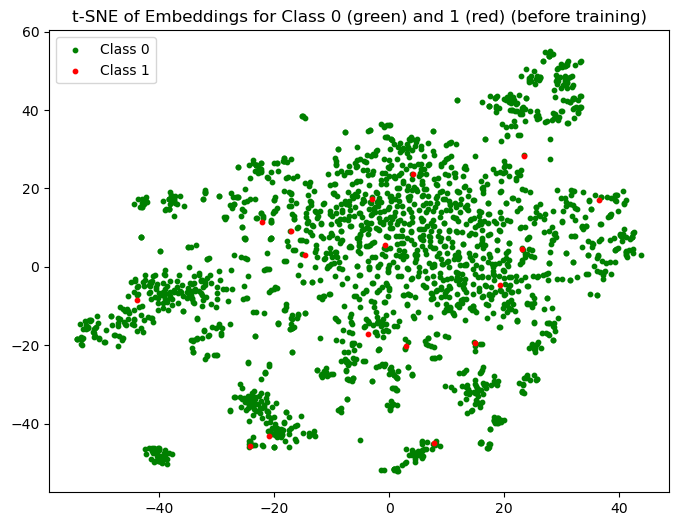

Epoch 001 | Loss: 0.8133 | AUC: 0.5964 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 002 | Loss: 0.8133 | AUC: 0.6056 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 003 | Loss: 0.8132 | AUC: 0.6133 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 004 | Loss: 0.8132 | AUC: 0.6223 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 005 | Loss: 0.8132 | AUC: 0.6295 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 006 | Loss: 0.8131 | AUC: 0.6372 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 007 | Loss: 0.8131 | AUC: 0.6441 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 008 | Loss: 0.8130 | AUC: 0.6506 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 009 | Loss: 0.8128 | AUC: 0.6577 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 010 | Loss: 0.8126 | AUC: 0.6653 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 011 | Loss: 0.8123 | AUC: 0.6714 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 012 | Loss: 0.8

In [372]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GAE
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Define Encoder
class GAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# Model & Optimizer
in_feats = data.num_node_features
hidden_dim = 256
out_dim = 128
encoder = GAEEncoder(in_feats, hidden_dim, out_dim)
gae_model = GAE(encoder)
optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.0001)
bce_loss = torch.nn.BCEWithLogitsLoss()

# Get training subgraph (time step 1)
train_batch = dataset[0]

visualize_tsne_binary(gae_model, train_batch, stage='before')

def train_single_graph(train_batch):

    loss_list, auc_list, f1_list, precision_list, recall_list = [], [], [], [], []
    epochs = 300

    for epoch in range(1, epochs + 1):
        _ = gae_model.train()
        optimizer.zero_grad()

        # Forward
        z = gae_model.encode(train_batch.x.squeeze(0), train_batch.edge_index.squeeze(0))
        edge_label_index = train_batch.edge_label_index.squeeze(0)
        edge_label = train_batch.edge_label.squeeze(0).float()
        logits = gae_model.decode(z, edge_label_index).view(-1)

        # Loss
        loss = bce_loss(logits, edge_label)
        loss.backward()
        optimizer.step()

        # Evaluation
        with torch.no_grad():
            probs = torch.sigmoid(logits).cpu()
            # print(f"probs: {probs}")
            # print(f"edge_label_index: {edge_label_index}")
            preds = (probs > 0.5).float()
            labels = edge_label.cpu()

            auc = roc_auc_score(labels, probs)
            f1 = f1_score(labels, preds)
            precision = precision_score(labels, preds)
            recall = recall_score(labels, preds)

            # Save metrics
            loss_list.append(loss.item())
            auc_list.append(auc)
            f1_list.append(f1)
            precision_list.append(precision)
            recall_list.append(recall)

            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    
    return loss_list, auc_list, f1_list, precision_list, recall_list

loss_list, auc_list, f1_list, precision_list, recall_list = train_single_graph(train_batch)

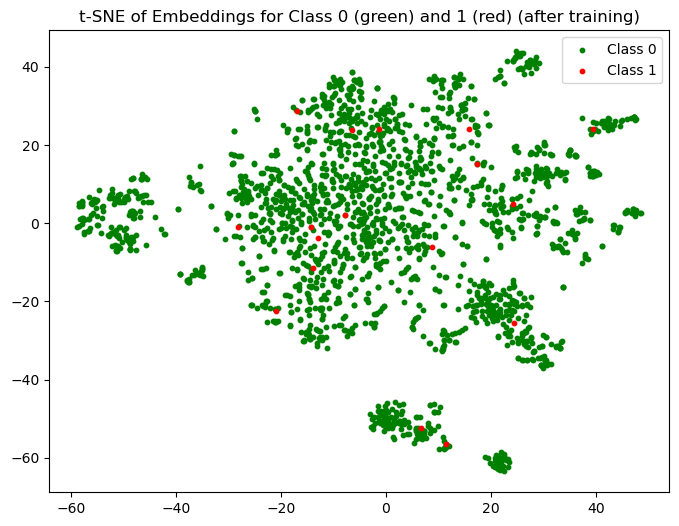

In [373]:
visualize_tsne_binary(gae_model, train_batch, stage='after')

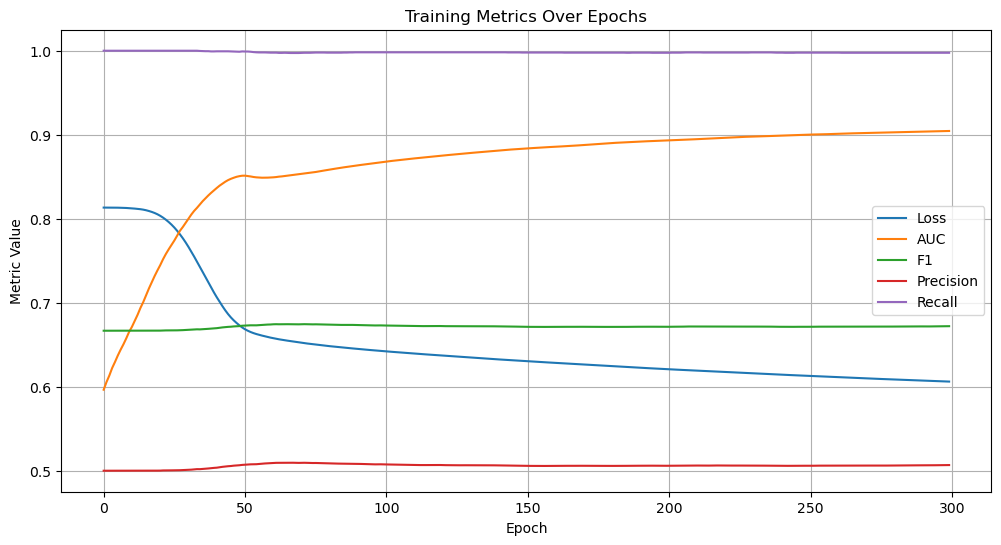

In [374]:
plt.figure(figsize=(12, 6))
plt.plot(loss_list, label='Loss')
plt.plot(auc_list, label='AUC')
plt.plot(f1_list, label='F1')
plt.plot(precision_list, label='Precision')
plt.plot(recall_list, label='Recall')
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Min score: 0.5000, Max score: 0.7311
Fraction > 0.5: 0.9842


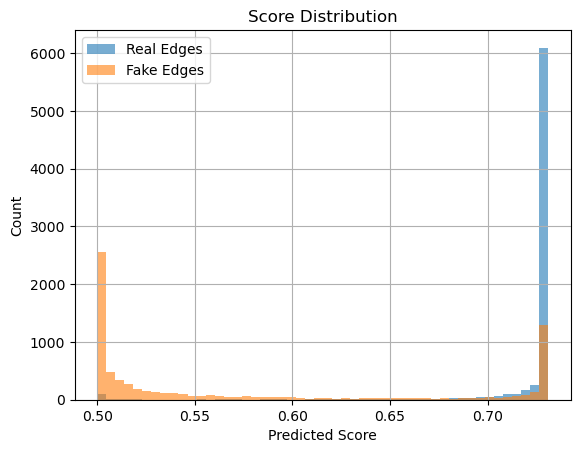

In [375]:
with torch.no_grad():
    _ = gae_model.eval()
    z = gae_model.encode(train_batch.x.squeeze(0), train_batch.edge_index.squeeze(0))
    logits = gae_model.decode(z, train_batch.edge_label_index.squeeze(0)).view(-1)
    probs = torch.sigmoid(logits).cpu()
    
    print(f"Min score: {probs.min().item():.4f}, Max score: {probs.max().item():.4f}")
    print(f"Fraction > 0.5: {(probs > 0.5).float().mean().item():.4f}")
    labels = train_batch.edge_label.squeeze(0).cpu()

    real_scores = probs[labels == 1]
    fake_scores = probs[labels == 0]

    plt.hist(real_scores.numpy(), bins=50, alpha=0.6, label='Real Edges')
    plt.hist(fake_scores.numpy(), bins=50, alpha=0.6, label='Fake Edges')
    plt.xlabel("Predicted Score")
    plt.ylabel("Count")
    plt.title("Score Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()

## Train on all sub-graph (1 ~ 41 only)

300 epochs for each sub-graph 

In [380]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GAE
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Define Encoder
class GAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# Model & Optimizer
in_feats = data.num_node_features
hidden_dim = 128
out_dim = 64
encoder = GAEEncoder(in_feats, hidden_dim, out_dim)
gae_model = GAE(encoder)
optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.0001)
bce_loss = torch.nn.BCEWithLogitsLoss()

def train_single_graph(train_batch):

    loss_list, auc_list, f1_list, precision_list, recall_list = [], [], [], [], []
    epochs = 300

    for epoch in range(1, epochs + 1):
        _ = gae_model.train()
        optimizer.zero_grad()

        # Forward
        z = gae_model.encode(train_batch.x.squeeze(0), train_batch.edge_index.squeeze(0))
        edge_label_index = train_batch.edge_label_index.squeeze(0)
        edge_label = train_batch.edge_label.squeeze(0).float()
        logits = gae_model.decode(z, edge_label_index).view(-1)

        # Loss
        loss = bce_loss(logits, edge_label)
        loss.backward()
        optimizer.step()

        # Evaluation
        with torch.no_grad():
            probs = torch.sigmoid(logits).cpu()
            preds = (probs > 0.5).float()
            labels = edge_label.cpu()

            auc = roc_auc_score(labels, probs)
            f1 = f1_score(labels, preds)
            precision = precision_score(labels, preds)
            recall = recall_score(labels, preds)

            # Save metrics
            loss_list.append(loss.item())
            auc_list.append(auc)
            f1_list.append(f1)
            precision_list.append(precision)
            recall_list.append(recall)

            # print(f"probs: {probs}")
            # print(f"edge_label_index: {edge_label_index}")
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | AUC: {auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    
    return loss_list, auc_list, f1_list, precision_list, recall_list

# print(train_batch)
for t, train_batch in enumerate(dataset):
    if t > 40: break
    print(f"t={t}, train_batch={train_batch}")
    loss_list, auc_list, f1_list, precision_list, recall_list = train_single_graph(train_batch)

t=0, train_batch=Data(x=[7844, 182], edge_index=[2, 7317], y=[7844], num_nodes=7844, node_time=[7844], edge_label=[14634], edge_label_index=[2, 14634])
Epoch 001 | Loss: 0.8107 | AUC: 0.7257 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 002 | Loss: 0.8102 | AUC: 0.7295 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 003 | Loss: 0.8097 | AUC: 0.7331 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 004 | Loss: 0.8091 | AUC: 0.7367 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 005 | Loss: 0.8084 | AUC: 0.7399 | F1: 0.6667 | Precision: 0.5000 | Recall: 1.0000
Epoch 006 | Loss: 0.8077 | AUC: 0.7436 | F1: 0.6667 | Precision: 0.5001 | Recall: 1.0000
Epoch 007 | Loss: 0.8068 | AUC: 0.7471 | F1: 0.6667 | Precision: 0.5001 | Recall: 1.0000
Epoch 008 | Loss: 0.8059 | AUC: 0.7501 | F1: 0.6667 | Precision: 0.5001 | Recall: 1.0000
Epoch 009 | Loss: 0.8048 | AUC: 0.7537 | F1: 0.6667 | Precision: 0.5001 | Recall: 1.0000
Epoch 010 | Loss: 0.8036 | AUC: 0.7569 | F1: 0.

In [381]:
train_mask = (data.y != 2) & data.train_mask
test_mask  = (data.y != 2) & data.test_mask

y_train = data.y[train_mask].cpu().numpy()
y_test  = data.y[test_mask].cpu().numpy()

### RF classifier with only GNE (GAE Node Embedding)

In [ ]:
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# get node embeddings
gae_model.eval()  # Important: turn off dropout etc. during inference
with torch.no_grad():
    z = gae_model.encode(data.x, data.edge_index)  # z is of shape [num_nodes, out_dim]


X_train = z[train_mask].cpu().numpy()
X_test  = z[test_mask].cpu().numpy()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec  = recall_score(y_test, y_pred, average='macro')
f1   = f1_score(y_test, y_pred, average='macro')

print(f"Random Forest - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

Random Forest - Acc: 0.9395, Prec: 0.8352, Rec: 0.5674, F1: 0.6006


### RF classifier with GNE + AF

In [ ]:
z_augmented = torch.cat([data.x, z], dim=1)  # shape: [202804, 310]

X_train_aug = z_augmented[train_mask].cpu().numpy()
X_test_aug  = z_augmented[test_mask].cpu().numpy()

rf_aug = RandomForestClassifier(n_estimators=100, random_state=42)
rf_aug.fit(X_train_aug, y_train)

y_pred_aug = rf_aug.predict(X_test_aug)

acc  = accuracy_score(y_test, y_pred_aug)
prec = precision_score(y_test, y_pred_aug, average='macro')
rec  = recall_score(y_test, y_pred_aug, average='macro')
f1   = f1_score(y_test, y_pred_aug, average='macro')

print(f"Random Forest - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

Random Forest - Acc: 0.9801, Prec: 0.9793, Rec: 0.8568, F1: 0.9077


### RF Classifier with only AF

In [ ]:
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train_af = data.x[train_mask].cpu().numpy()
X_test_af  = data.x[test_mask].cpu().numpy()

rf_af = RandomForestClassifier(n_estimators=50, random_state=42)
rf_af.fit(X_train_af, y_train)

y_pred_af = rf_af.predict(X_test_af)

acc  = accuracy_score(y_test, y_pred_af)
prec = precision_score(y_test, y_pred_af, average='macro')
rec  = recall_score(y_test, y_pred_af, average='macro')
f1   = f1_score(y_test, y_pred_af, average='macro')

print(f"Random Forest - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

Random Forest - Acc: 0.9794, Prec: 0.9700, Rec: 0.8590, F1: 0.9059


## GAE, GCN

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from sklearn.metrics import f1_score, precision_score, recall_score

class NodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.lin = torch.nn.Linear(in_channels, num_classes)
    def forward(self, z):
        return self.lin(z)

in_feats    = data.num_node_features
hidden_dim  = 256
out_dim     = 128
num_classes = int(data.y[data.y != 2].max() + 1)

classifier = NodeClassifier(out_dim, num_classes)

optimizer = torch.optim.Adam(
    list(classifier.parameters()),
    lr=0.001
)
ce_loss  = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# get node embeddings
gae_model.eval()  # Important: turn off dropout etc. during inference
with torch.no_grad():
    z = gae_model.encode(data.x, data.edge_index)  # z is of shape [num_nodes, out_dim]

# training loop
for epoch in range(300):
    classifier.train()
    optimizer.zero_grad()
    out = classifier(z)  # shape [num_nodes, num_classes]
    train_mask = (data.y != 2) & data.train_mask
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

classifier.eval()
with torch.no_grad():
    out = classifier(z)
    pred = out.argmax(dim=1)
    test_mask = (data.y != 2) & data.test_mask
    acc = (pred[test_mask] == data.y[test_mask]).float().mean()
    prec = precision_score(data.y[test_mask], pred[test_mask], average='macro')
    rec  = recall_score(data.y[test_mask], pred[test_mask], average='macro')
    f1   = f1_score(data.y[test_mask], pred[test_mask], average='macro')
    print(f"Test Acc={acc:.4f} | "
            f"Precision={prec:.4f} | "
            f"Recall={rec:.4f} | "
            f"F1={f1:.4f}")



Epoch 0, Loss: 0.8139
Epoch 1, Loss: 0.4654
Epoch 2, Loss: 0.3829
Epoch 3, Loss: 0.3674
Epoch 4, Loss: 0.3713
Epoch 5, Loss: 0.3794
Epoch 6, Loss: 0.3857
Epoch 7, Loss: 0.3882
Epoch 8, Loss: 0.3870
Epoch 9, Loss: 0.3830
Epoch 10, Loss: 0.3772
Epoch 11, Loss: 0.3710
Epoch 12, Loss: 0.3657
Epoch 13, Loss: 0.3621
Epoch 14, Loss: 0.3605
Epoch 15, Loss: 0.3602
Epoch 16, Loss: 0.3599
Epoch 17, Loss: 0.3584
Epoch 18, Loss: 0.3551
Epoch 19, Loss: 0.3501
Epoch 20, Loss: 0.3442
Epoch 21, Loss: 0.3382
Epoch 22, Loss: 0.3330
Epoch 23, Loss: 0.3288
Epoch 24, Loss: 0.3254
Epoch 25, Loss: 0.3226
Epoch 26, Loss: 0.3200
Epoch 27, Loss: 0.3172
Epoch 28, Loss: 0.3141
Epoch 29, Loss: 0.3110
Epoch 30, Loss: 0.3079
Epoch 31, Loss: 0.3051
Epoch 32, Loss: 0.3027
Epoch 33, Loss: 0.3008
Epoch 34, Loss: 0.2991
Epoch 35, Loss: 0.2974
Epoch 36, Loss: 0.2958
Epoch 37, Loss: 0.2940
Epoch 38, Loss: 0.2922
Epoch 39, Loss: 0.2907
Epoch 40, Loss: 0.2895
Epoch 41, Loss: 0.2887
Epoch 42, Loss: 0.2881
Epoch 43, Loss: 0.287